<a href="https://colab.research.google.com/github/AI-Lab-2025-2-3rd/ai-project-hyeongnim/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%88%98%ED%96%89%ED%8F%89%EA%B0%80_%EB%B0%98%EB%8F%84%EC%B2%B4_%EC%86%8C%EC%9E%90_%EC%9D%B4%EC%83%81%ED%83%90%EC%A7%80_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from skimage.transform import resize as sk_resize

In [2]:
import zipfile

with zipfile.ZipFile("/content/data.zip", 'r') as target_file:
    target_file.extractall('/content/data')

In [3]:
# 데이터 로딩 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로.
            transform (callable, optional): 샘플에 적용될 Optional transform.
        """
        self.df = pd.read_csv(csv_file)
        # Assuming the image paths in the CSV are relative and the images are extracted to /content/data/open/
        self.df["img_path"] = self.df["img_path"].apply(lambda x: os.path.join("/content/data/open", x))
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df["img_path"].iloc[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        target = torch.tensor([0.0]).float()
        return image, target


# 이미지 전처리 및 임베딩
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),  # NOTE: 256 x 256 resize
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
device = torch.device("cuda")
memory_bank_path = "./memory_bank/resnet18"  # memory bank를 저장할 경로

In [5]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

model.eval()
test = nn.Sequential(*list(model.children())[:-3])
model = model.to(device)

# 기호 정리:
# N: batch size
# N': memory bank size
# query: query size
# D: target_dim
# |A|: patch collection size
# |P|: patch_size


# Patchcore Implementation - https://arxiv.org/abs/2106.08265
class PatchCore(nn.Module):
    def __init__(
        self,
        backbone,
        per_memory_bank_size=4,
        memory_bank_path="./memory_bank",
        device=device,
        target_dim=384 * 3,  # |D|
        patch_size=3,  # |P|
        d=3,  # nearest
    ):
        """
        Args:
            backbone: torch.nn.Module
            per_memory_bank_size: int
            memory_bank_path: str
            device: torch.device
            target_dim: int
            patch_size: int
            d: int
        """

        super().__init__()
        self.backbone = model
        self.backbone.eval()

        self.layer2_output, self.layer3_output = None, None
        self.register_hook_for_layer2()  # register hook for layer2
        self.register_hook_for_layer3()  # register hook for layer3

        self.memory_bank = None
        self.per_memory_bank_size = per_memory_bank_size
        self.memory_bank_path = memory_bank_path
        self.device = device
        self.target_dim = target_dim
        self.average_pool = nn.AdaptiveAvgPool1d(self.target_dim)
        self.patch_size = patch_size
        self.d = d

    def register_hook_for_layer2(self):
        self.backbone.layer2.register_forward_hook(self._register_hook_for_layer2)

    def _register_hook_for_layer2(self, module, input, output):  # (B, 128, 28, 28)
        layer2_output = output
        self.layer2_output = layer2_output  # (B, 128, 28, 28)
        # self.layer2_output = None

    def register_hook_for_layer3(self):
        self.backbone.layer3.register_forward_hook(self._register_hook_for_layer3)

    def _register_hook_for_layer3(self, module, input, output):  # (B, 256, 14, 14)
        layer3_output = output
        layer3_output = nn.functional.interpolate(
            layer3_output, scale_factor=2, mode="bilinear"
        )
        self.layer3_output = layer3_output  # (B, 256, 28, 28)

    def save_memory_bank(self, train_batch, file_name):
        """
        training batch를 받아서 memory bank에 저장한다.
        """
        self.backbone(train_batch)
        path = os.path.join(self.memory_bank_path, file_name)
        new_memory = self.patch_collection(self.patch_size)
        new_memory = new_memory.reshape(-1, new_memory.shape[-1])
        torch.save(new_memory, path)

    def loader_memory_bank(self):
        """
        memory bank를 이터레이터로 불러온다.
        """
        file_list = os.listdir(self.memory_bank_path)
        file_list = [file for file in file_list if file.endswith(".pth")]
        file_list.sort()
        for file in file_list:
            path = os.path.join(self.memory_bank_path, file)
            new_memory = torch.load(path, map_location=self.device)

            yield new_memory

    def forward(self, x):
        self.backbone(x)
        query = self.patch_collection(self.patch_size)  # (N, |A|, D)
        l2 = torch.Tensor([]).to(device)
        for memory in self.loader_memory_bank():
            l2 = torch.cat((l2, self.cal_l2(query, memory)), dim=1)
            del memory

        s_ = self.get_anomaly_score(l2)
        s = self.update_anomaly_score(s_, l2, self.d)
        return s

    def get_anomaly_score(self, l2):
        """
        Args:
            l2: (query, N', |A|)
        """
        min_l2 = l2.min(dim=1).values  # (query, |A|)
        max_min_l2 = min_l2.max(dim=1).values  # (query, )
        return max_min_l2

    def update_anomaly_score(self, s_, l2: torch.Tensor, d):
        """
        Args:
            l2: (query, N', |A|)
            d = nearest
        """
        m_train = l2.min(dim=1)  # (query, |A|)
        m_test = m_train.values.max(dim=1)  # (query)
        m_for_test = l2[:, :, m_test.indices]  # (query, N')
        m_train_nearest = m_for_test.topk(k=d, dim=1).values  # (query, d)

        update_weight = 1 - (
            torch.exp(m_test.values) / torch.exp(m_train_nearest).sum(dim=1)
        )
        s = s_ * update_weight
        return s

    def cal_l2(self, query, memory_bank):
        """
        return: (query_size, memory_bank_size, |A|)
        """
        memory_bank = memory_bank.unsqueeze(1)  # (N', 1, D)
        N, D = memory_bank.shape[0], memory_bank.shape[2]
        memory_bank = memory_bank.expand(N, query.shape[1], D)  # (N', |A|, D)
        l2 = []
        for q in query:
            q = q.unsqueeze(0)  # (1, |A|, D)
            diff = memory_bank - q  # (N', |A|, D)
            l2_ = diff.square().sum(dim=2)  # (N', |A|)
            l2_ = l2_.sqrt()
            l2.append(l2_)
            del q
        l2 = torch.stack(l2, dim=0)  # (query, N', |A|)
        return l2

    def feature(self, h, w):
        """
        return: (N, C)
        """
        H, W = self.layer2_output.shape[2], self.layer2_output.shape[3]
        if not (0 <= h < H and 0 <= w < W):
            return torch.tensor([]).to(self.device)
        layer2 = self.layer2_output[:, :, h, w]  # (B, C)

        # TODO: 아래 코드
        if self.layer3_output is not None:
            layer3 = self.layer3_output[:, :, h, w]  # (B, C')
        else:
            layer3 = torch.tensor([]).to(self.device)

        feature = torch.cat((layer2, layer3), dim=1)
        return feature

    def neighborhood_features(self, h, w, patch_size):
        """
        return: (N, |P|, C) -> path_size x patch_size
        """
        features = []
        for i in range(math.floor(-patch_size / 2), math.floor(patch_size / 2)):
            for j in range(math.floor(-patch_size / 2), math.floor(patch_size / 2)):
                feature = self.feature(h + i, w + j)
                if feature.shape[0] == 0:
                    continue
                features.append(feature)
        features = torch.stack(features, dim=1)
        return features

    def patch(self, h, w, patch_size):
        """
        return: (N, D)
        """
        features = self.neighborhood_features(h, w, patch_size)
        features = features.permute(0, 2, 1)  # (N, C, |P|)
        features = features.reshape(features.shape[0], -1)  # (N, C X |P|)
        features = self.average_pool(features)  # (N, target_dim) = (N, D)
        return features

    def patch_collection(self, patch_size):
        """
        return: (N, |A|, D)
        """
        H, W = self.layer2_output.shape[2], self.layer2_output.shape[3]

        patch_collection = []
        # average pooling으로 나눌 수 있게 중심만 고려한다.
        for h in range(math.ceil(patch_size / 2), H - math.ceil(patch_size / 2)):
            for w in range(math.ceil(patch_size / 2), W - math.ceil(patch_size / 2)):
                patch = self.patch(h, w, patch_size)
                patch_collection.append(patch)
        patch_collection = torch.stack(patch_collection, dim=1)
        return patch_collection

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


In [6]:
params = {
    "patch_size": 5,
    "per_memory_bank_size": 1,
    "d": 2,
    "target_dim": 1920,
}

In [7]:
k = 13  # Train data를 몇 개씩 slice할 것인지

In [9]:
# Threshold 구하기
data = pd.read_csv("/content/data/open/train.csv")
sum = 0.0
m = 213 // k


def save2(batch_size=1, config=dict()):  # Threshold 구하는 데 필요한 save 함수
    # memory_bank_path 폴더 초기화
    if os.path.exists(memory_bank_path):
        for file in os.listdir(memory_bank_path):
            os.remove(os.path.join(memory_bank_path, file))
    else:
        os.makedirs(memory_bank_path)

    patch_core = PatchCore(model, memory_bank_path=memory_bank_path, **config)
    train_data = CustomDataset(csv_file="./train2.csv", transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

    for idx, x in enumerate(tqdm(train_loader)):
        x = x[0].to(device)
        patch_core.save_memory_bank(x, f"memory_bank_{batch_size*idx}.pth")


for i in range(m):
    j = i * k
    validation_indices = range(j, j + 13)  # 13개씩 슬라이싱
    validation_idx = data.loc[validation_indices]
    train_idx = data.drop(validation_indices)

    train_idx.to_csv("./train2.csv", index=False)
    validation_idx.to_csv("./validation.csv", index=False)

    save2(batch_size=1, config=params)

    patch_core = PatchCore(model, memory_bank_path=memory_bank_path, **params)
    test_data = CustomDataset(csv_file="./validation.csv", transform=transform)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
    anomaly_score = torch.tensor([], device=device)
    with torch.no_grad():
        for idx, x in tqdm(enumerate(test_loader), desc="query"):
            x = x[0].to(device)
            l2 = patch_core.forward(x)

            print(f"l2: {l2}")

            anomaly_score = torch.cat([anomaly_score, l2], dim=0)
            anomaly_score_sorted_idx = anomaly_score.sort(descending=True).indices

    anomaly_score = anomaly_score.cpu()

    max_value, max_index = torch.max(anomaly_score, 0)
    print(f"{i+1}th slice max value : {max_value.item():.4f} \n")
    sum += max_value.item()

100%|██████████| 200/200 [02:21<00:00,  1.42it/s]
query: 1it [00:08,  8.66s/it]

l2: tensor([[4.6534]], device='cuda:0')


query: 2it [00:16,  8.39s/it]

l2: tensor([[4.5139]], device='cuda:0')


query: 3it [00:25,  8.30s/it]

l2: tensor([[4.2865]], device='cuda:0')


query: 4it [00:33,  8.26s/it]

l2: tensor([[4.1258]], device='cuda:0')


query: 5it [00:41,  8.23s/it]

l2: tensor([[4.0358]], device='cuda:0')


query: 6it [00:49,  8.22s/it]

l2: tensor([[4.8547]], device='cuda:0')


query: 7it [00:57,  8.22s/it]

l2: tensor([[4.0359]], device='cuda:0')


query: 8it [01:06,  8.21s/it]

l2: tensor([[4.5468]], device='cuda:0')


query: 9it [01:14,  8.29s/it]

l2: tensor([[4.3143]], device='cuda:0')


query: 10it [01:22,  8.27s/it]

l2: tensor([[4.0587]], device='cuda:0')


query: 11it [01:30,  8.25s/it]

l2: tensor([[4.4867]], device='cuda:0')


query: 12it [01:39,  8.29s/it]

l2: tensor([[3.9657]], device='cuda:0')


query: 13it [01:47,  8.27s/it]


l2: tensor([[3.8500]], device='cuda:0')
1th slice max value : 4.8547 



100%|██████████| 200/200 [02:18<00:00,  1.44it/s]
query: 1it [00:08,  8.41s/it]

l2: tensor([[4.5626]], device='cuda:0')


query: 2it [00:16,  8.28s/it]

l2: tensor([[4.3278]], device='cuda:0')


query: 3it [00:24,  8.23s/it]

l2: tensor([[4.2507]], device='cuda:0')


query: 4it [00:33,  8.31s/it]

l2: tensor([[4.4095]], device='cuda:0')


query: 5it [00:41,  8.28s/it]

l2: tensor([[4.6819]], device='cuda:0')


query: 6it [00:49,  8.25s/it]

l2: tensor([[4.3553]], device='cuda:0')


query: 7it [00:57,  8.23s/it]

l2: tensor([[3.8408]], device='cuda:0')


query: 8it [01:05,  8.22s/it]

l2: tensor([[4.4928]], device='cuda:0')


query: 9it [01:14,  8.21s/it]

l2: tensor([[3.8959]], device='cuda:0')


query: 10it [01:22,  8.20s/it]

l2: tensor([[4.6354]], device='cuda:0')


query: 11it [01:30,  8.20s/it]

l2: tensor([[4.1734]], device='cuda:0')


query: 12it [01:38,  8.20s/it]

l2: tensor([[4.3128]], device='cuda:0')


query: 13it [01:46,  8.23s/it]


l2: tensor([[3.8256]], device='cuda:0')
2th slice max value : 4.6819 



100%|██████████| 200/200 [02:19<00:00,  1.43it/s]
query: 1it [00:08,  8.18s/it]

l2: tensor([[4.1984]], device='cuda:0')


query: 2it [00:16,  8.17s/it]

l2: tensor([[4.2456]], device='cuda:0')


query: 3it [00:24,  8.26s/it]

l2: tensor([[4.1263]], device='cuda:0')


query: 4it [00:32,  8.23s/it]

l2: tensor([[4.1281]], device='cuda:0')


query: 5it [00:41,  8.21s/it]

l2: tensor([[4.7804]], device='cuda:0')


query: 6it [00:49,  8.28s/it]

l2: tensor([[4.2985]], device='cuda:0')


query: 7it [00:57,  8.25s/it]

l2: tensor([[4.8717]], device='cuda:0')


query: 8it [01:05,  8.24s/it]

l2: tensor([[4.4071]], device='cuda:0')


query: 9it [01:14,  8.24s/it]

l2: tensor([[3.7005]], device='cuda:0')


query: 10it [01:22,  8.23s/it]

l2: tensor([[4.4663]], device='cuda:0')


query: 11it [01:30,  8.21s/it]

l2: tensor([[4.0541]], device='cuda:0')


query: 12it [01:38,  8.22s/it]

l2: tensor([[4.4994]], device='cuda:0')


query: 13it [01:46,  8.23s/it]


l2: tensor([[4.2369]], device='cuda:0')
3th slice max value : 4.8717 



100%|██████████| 200/200 [02:20<00:00,  1.42it/s]
query: 1it [00:08,  8.18s/it]

l2: tensor([[4.1329]], device='cuda:0')


query: 2it [00:16,  8.29s/it]

l2: tensor([[4.1170]], device='cuda:0')


query: 3it [00:24,  8.24s/it]

l2: tensor([[4.4735]], device='cuda:0')


query: 4it [00:32,  8.22s/it]

l2: tensor([[4.2069]], device='cuda:0')


query: 5it [00:41,  8.29s/it]

l2: tensor([[4.2182]], device='cuda:0')


query: 6it [00:49,  8.26s/it]

l2: tensor([[3.9861]], device='cuda:0')


query: 7it [00:57,  8.24s/it]

l2: tensor([[4.0904]], device='cuda:0')


query: 8it [01:05,  8.23s/it]

l2: tensor([[4.3560]], device='cuda:0')


query: 9it [01:14,  8.22s/it]

l2: tensor([[3.7058]], device='cuda:0')


query: 10it [01:22,  8.22s/it]

l2: tensor([[4.2802]], device='cuda:0')


query: 11it [01:30,  8.21s/it]

l2: tensor([[4.0485]], device='cuda:0')


query: 12it [01:38,  8.21s/it]

l2: tensor([[4.0574]], device='cuda:0')


query: 13it [01:46,  8.23s/it]


l2: tensor([[3.8688]], device='cuda:0')
4th slice max value : 4.4735 



100%|██████████| 200/200 [02:18<00:00,  1.44it/s]
query: 1it [00:08,  8.21s/it]

l2: tensor([[3.8398]], device='cuda:0')


query: 2it [00:16,  8.18s/it]

l2: tensor([[4.2128]], device='cuda:0')


query: 3it [00:24,  8.18s/it]

l2: tensor([[3.8116]], device='cuda:0')


query: 4it [00:32,  8.22s/it]

l2: tensor([[4.2772]], device='cuda:0')


query: 5it [00:41,  8.21s/it]

l2: tensor([[4.6765]], device='cuda:0')


query: 6it [00:49,  8.21s/it]

l2: tensor([[4.5254]], device='cuda:0')


query: 7it [00:57,  8.28s/it]

l2: tensor([[3.9025]], device='cuda:0')


query: 8it [01:05,  8.26s/it]

l2: tensor([[4.8719]], device='cuda:0')


query: 9it [01:14,  8.24s/it]

l2: tensor([[4.8159]], device='cuda:0')


query: 10it [01:22,  8.28s/it]

l2: tensor([[3.6794]], device='cuda:0')


query: 11it [01:30,  8.26s/it]

l2: tensor([[4.0921]], device='cuda:0')


query: 12it [01:38,  8.24s/it]

l2: tensor([[4.2923]], device='cuda:0')


query: 13it [01:47,  8.23s/it]


l2: tensor([[4.4174]], device='cuda:0')
5th slice max value : 4.8719 



100%|██████████| 200/200 [02:19<00:00,  1.44it/s]
query: 1it [00:08,  8.18s/it]

l2: tensor([[4.2795]], device='cuda:0')


query: 2it [00:16,  8.17s/it]

l2: tensor([[4.2600]], device='cuda:0')


query: 3it [00:24,  8.17s/it]

l2: tensor([[4.9527]], device='cuda:0')


query: 4it [00:32,  8.18s/it]

l2: tensor([[4.4119]], device='cuda:0')


query: 5it [00:40,  8.18s/it]

l2: tensor([[4.1152]], device='cuda:0')


query: 6it [00:49,  8.19s/it]

l2: tensor([[4.3364]], device='cuda:0')


query: 7it [00:57,  8.20s/it]

l2: tensor([[4.0822]], device='cuda:0')


query: 8it [01:05,  8.20s/it]

l2: tensor([[3.8792]], device='cuda:0')


query: 9it [01:13,  8.27s/it]

l2: tensor([[4.1382]], device='cuda:0')


query: 10it [01:22,  8.25s/it]

l2: tensor([[4.2542]], device='cuda:0')


query: 11it [01:30,  8.23s/it]

l2: tensor([[4.4201]], device='cuda:0')


query: 12it [01:38,  8.28s/it]

l2: tensor([[4.4331]], device='cuda:0')


query: 13it [01:46,  8.22s/it]


l2: tensor([[4.5183]], device='cuda:0')
6th slice max value : 4.9527 



100%|██████████| 200/200 [02:18<00:00,  1.45it/s]
query: 1it [00:08,  8.39s/it]

l2: tensor([[3.7700]], device='cuda:0')


query: 2it [00:16,  8.25s/it]

l2: tensor([[5.3926]], device='cuda:0')


query: 3it [00:24,  8.21s/it]

l2: tensor([[4.7597]], device='cuda:0')


query: 4it [00:33,  8.30s/it]

l2: tensor([[3.6234]], device='cuda:0')


query: 5it [00:41,  8.26s/it]

l2: tensor([[4.2689]], device='cuda:0')


query: 6it [00:49,  8.24s/it]

l2: tensor([[4.4347]], device='cuda:0')


query: 7it [00:57,  8.24s/it]

l2: tensor([[4.4576]], device='cuda:0')


query: 8it [01:05,  8.23s/it]

l2: tensor([[4.5130]], device='cuda:0')


query: 9it [01:14,  8.22s/it]

l2: tensor([[4.6036]], device='cuda:0')


query: 10it [01:22,  8.22s/it]

l2: tensor([[4.3700]], device='cuda:0')


query: 11it [01:30,  8.22s/it]

l2: tensor([[3.9461]], device='cuda:0')


query: 12it [01:38,  8.21s/it]

l2: tensor([[4.2833]], device='cuda:0')


query: 13it [01:46,  8.23s/it]


l2: tensor([[3.7069]], device='cuda:0')
7th slice max value : 5.3926 



100%|██████████| 200/200 [02:18<00:00,  1.44it/s]
query: 1it [00:08,  8.17s/it]

l2: tensor([[4.0041]], device='cuda:0')


query: 2it [00:16,  8.16s/it]

l2: tensor([[4.7828]], device='cuda:0')


query: 3it [00:24,  8.20s/it]

l2: tensor([[6.6086]], device='cuda:0')


query: 4it [00:32,  8.19s/it]

l2: tensor([[4.4041]], device='cuda:0')


query: 5it [00:40,  8.18s/it]

l2: tensor([[3.7943]], device='cuda:0')


query: 6it [00:49,  8.25s/it]

l2: tensor([[4.5121]], device='cuda:0')


query: 7it [00:57,  8.23s/it]

l2: tensor([[4.5858]], device='cuda:0')


query: 8it [01:05,  8.22s/it]

l2: tensor([[4.5184]], device='cuda:0')


query: 9it [01:14,  8.29s/it]

l2: tensor([[3.9832]], device='cuda:0')


query: 10it [01:22,  8.26s/it]

l2: tensor([[4.3824]], device='cuda:0')


query: 11it [01:30,  8.24s/it]

l2: tensor([[4.3729]], device='cuda:0')


query: 12it [01:38,  8.23s/it]

l2: tensor([[4.1696]], device='cuda:0')


query: 13it [01:46,  8.22s/it]


l2: tensor([[4.0442]], device='cuda:0')
8th slice max value : 6.6086 



100%|██████████| 200/200 [02:18<00:00,  1.44it/s]
query: 1it [00:08,  8.29s/it]

l2: tensor([[3.9472]], device='cuda:0')


query: 2it [00:16,  8.22s/it]

l2: tensor([[4.2858]], device='cuda:0')


query: 3it [00:24,  8.19s/it]

l2: tensor([[4.0106]], device='cuda:0')


query: 4it [00:32,  8.19s/it]

l2: tensor([[3.8859]], device='cuda:0')


query: 5it [00:40,  8.19s/it]

l2: tensor([[4.2403]], device='cuda:0')


query: 6it [00:49,  8.19s/it]

l2: tensor([[4.3013]], device='cuda:0')


query: 7it [00:57,  8.19s/it]

l2: tensor([[4.2484]], device='cuda:0')


query: 8it [01:05,  8.19s/it]

l2: tensor([[4.4178]], device='cuda:0')


query: 9it [01:13,  8.19s/it]

l2: tensor([[4.0252]], device='cuda:0')


query: 10it [01:21,  8.20s/it]

l2: tensor([[4.8850]], device='cuda:0')


query: 11it [01:30,  8.26s/it]

l2: tensor([[4.1932]], device='cuda:0')


query: 12it [01:38,  8.24s/it]

l2: tensor([[4.8898]], device='cuda:0')


query: 13it [01:46,  8.21s/it]


l2: tensor([[4.4628]], device='cuda:0')
9th slice max value : 4.8898 



100%|██████████| 200/200 [02:18<00:00,  1.45it/s]
query: 1it [00:08,  8.17s/it]

l2: tensor([[4.1689]], device='cuda:0')


query: 2it [00:16,  8.16s/it]

l2: tensor([[4.2611]], device='cuda:0')


query: 3it [00:24,  8.26s/it]

l2: tensor([[4.2272]], device='cuda:0')


query: 4it [00:32,  8.24s/it]

l2: tensor([[4.0471]], device='cuda:0')


query: 5it [00:41,  8.22s/it]

l2: tensor([[4.1892]], device='cuda:0')


query: 6it [00:49,  8.29s/it]

l2: tensor([[4.2853]], device='cuda:0')


query: 7it [00:57,  8.26s/it]

l2: tensor([[4.2888]], device='cuda:0')


query: 8it [01:05,  8.25s/it]

l2: tensor([[3.7520]], device='cuda:0')


query: 9it [01:14,  8.24s/it]

l2: tensor([[4.2684]], device='cuda:0')


query: 10it [01:22,  8.22s/it]

l2: tensor([[4.3081]], device='cuda:0')


query: 11it [01:30,  8.22s/it]

l2: tensor([[4.5953]], device='cuda:0')


query: 12it [01:38,  8.21s/it]

l2: tensor([[4.4403]], device='cuda:0')


query: 13it [01:46,  8.23s/it]


l2: tensor([[4.4066]], device='cuda:0')
10th slice max value : 4.5953 



100%|██████████| 200/200 [02:18<00:00,  1.45it/s]
query: 1it [00:08,  8.17s/it]

l2: tensor([[4.5368]], device='cuda:0')


query: 2it [00:16,  8.17s/it]

l2: tensor([[4.5318]], device='cuda:0')


query: 3it [00:24,  8.16s/it]

l2: tensor([[4.8810]], device='cuda:0')


query: 4it [00:32,  8.16s/it]

l2: tensor([[4.7923]], device='cuda:0')


query: 5it [00:40,  8.17s/it]

l2: tensor([[6.8897]], device='cuda:0')


query: 6it [00:49,  8.18s/it]

l2: tensor([[5.1297]], device='cuda:0')


query: 7it [00:57,  8.19s/it]

l2: tensor([[4.0705]], device='cuda:0')


query: 8it [01:05,  8.22s/it]

l2: tensor([[4.4501]], device='cuda:0')


query: 9it [01:13,  8.22s/it]

l2: tensor([[4.9111]], device='cuda:0')


query: 10it [01:21,  8.21s/it]

l2: tensor([[3.9104]], device='cuda:0')


query: 11it [01:30,  8.27s/it]

l2: tensor([[4.3815]], device='cuda:0')


query: 12it [01:38,  8.25s/it]

l2: tensor([[3.7596]], device='cuda:0')


query: 13it [01:46,  8.21s/it]


l2: tensor([[4.5025]], device='cuda:0')
11th slice max value : 6.8897 



100%|██████████| 200/200 [02:18<00:00,  1.45it/s]
query: 1it [00:08,  8.19s/it]

l2: tensor([[4.4966]], device='cuda:0')


query: 2it [00:16,  8.17s/it]

l2: tensor([[4.2123]], device='cuda:0')


query: 3it [00:24,  8.26s/it]

l2: tensor([[4.2364]], device='cuda:0')


query: 4it [00:32,  8.23s/it]

l2: tensor([[4.2056]], device='cuda:0')


query: 5it [00:41,  8.21s/it]

l2: tensor([[3.8726]], device='cuda:0')


query: 6it [00:49,  8.24s/it]

l2: tensor([[4.2615]], device='cuda:0')


query: 7it [00:57,  8.22s/it]

l2: tensor([[4.3126]], device='cuda:0')


query: 8it [01:05,  8.22s/it]

l2: tensor([[3.8796]], device='cuda:0')


query: 9it [01:13,  8.21s/it]

l2: tensor([[4.2422]], device='cuda:0')


query: 10it [01:22,  8.21s/it]

l2: tensor([[4.2809]], device='cuda:0')


query: 11it [01:30,  8.20s/it]

l2: tensor([[3.6575]], device='cuda:0')


query: 12it [01:38,  8.20s/it]

l2: tensor([[4.2853]], device='cuda:0')


query: 13it [01:46,  8.21s/it]


l2: tensor([[4.4739]], device='cuda:0')
12th slice max value : 4.4966 



100%|██████████| 200/200 [02:19<00:00,  1.44it/s]
query: 1it [00:08,  8.17s/it]

l2: tensor([[4.3441]], device='cuda:0')


query: 2it [00:16,  8.18s/it]

l2: tensor([[6.2458]], device='cuda:0')


query: 3it [00:24,  8.18s/it]

l2: tensor([[4.0465]], device='cuda:0')


query: 4it [00:32,  8.19s/it]

l2: tensor([[4.3057]], device='cuda:0')


query: 5it [00:41,  8.28s/it]

l2: tensor([[4.0022]], device='cuda:0')


query: 6it [00:49,  8.25s/it]

l2: tensor([[3.6947]], device='cuda:0')


query: 7it [00:57,  8.23s/it]

l2: tensor([[4.3276]], device='cuda:0')


query: 8it [01:06,  8.30s/it]

l2: tensor([[4.2221]], device='cuda:0')


query: 9it [01:14,  8.27s/it]

l2: tensor([[4.0520]], device='cuda:0')


query: 10it [01:22,  8.25s/it]

l2: tensor([[3.8334]], device='cuda:0')


query: 11it [01:30,  8.23s/it]

l2: tensor([[3.9752]], device='cuda:0')


query: 12it [01:38,  8.23s/it]

l2: tensor([[4.4320]], device='cuda:0')


query: 13it [01:47,  8.23s/it]


l2: tensor([[3.9062]], device='cuda:0')
13th slice max value : 6.2458 



100%|██████████| 200/200 [02:18<00:00,  1.45it/s]
query: 1it [00:08,  8.19s/it]

l2: tensor([[4.1389]], device='cuda:0')


query: 2it [00:16,  8.17s/it]

l2: tensor([[4.0004]], device='cuda:0')


query: 3it [00:24,  8.17s/it]

l2: tensor([[4.6590]], device='cuda:0')


query: 4it [00:32,  8.18s/it]

l2: tensor([[4.4225]], device='cuda:0')


query: 5it [00:40,  8.19s/it]

l2: tensor([[5.1519]], device='cuda:0')


query: 6it [00:49,  8.19s/it]

l2: tensor([[4.1778]], device='cuda:0')


query: 7it [00:57,  8.20s/it]

l2: tensor([[4.0925]], device='cuda:0')


query: 8it [01:05,  8.20s/it]

l2: tensor([[4.6252]], device='cuda:0')


query: 9it [01:13,  8.20s/it]

l2: tensor([[4.0268]], device='cuda:0')


query: 10it [01:22,  8.25s/it]

l2: tensor([[4.1577]], device='cuda:0')


query: 11it [01:30,  8.23s/it]

l2: tensor([[4.0583]], device='cuda:0')


query: 12it [01:38,  8.22s/it]

l2: tensor([[4.1207]], device='cuda:0')


query: 13it [01:46,  8.22s/it]


l2: tensor([[4.3856]], device='cuda:0')
14th slice max value : 5.1519 



100%|██████████| 200/200 [02:18<00:00,  1.44it/s]
query: 1it [00:08,  8.21s/it]

l2: tensor([[4.2543]], device='cuda:0')


query: 2it [00:16,  8.31s/it]

l2: tensor([[4.9847]], device='cuda:0')


query: 3it [00:24,  8.26s/it]

l2: tensor([[4.0674]], device='cuda:0')


query: 4it [00:32,  8.23s/it]

l2: tensor([[4.4658]], device='cuda:0')


query: 5it [00:41,  8.28s/it]

l2: tensor([[4.1054]], device='cuda:0')


query: 6it [00:49,  8.25s/it]

l2: tensor([[5.6317]], device='cuda:0')


query: 7it [00:57,  8.24s/it]

l2: tensor([[4.1007]], device='cuda:0')


query: 8it [01:05,  8.23s/it]

l2: tensor([[4.2399]], device='cuda:0')


query: 9it [01:14,  8.22s/it]

l2: tensor([[4.2364]], device='cuda:0')


query: 10it [01:22,  8.21s/it]

l2: tensor([[4.1446]], device='cuda:0')


query: 11it [01:30,  8.21s/it]

l2: tensor([[4.2130]], device='cuda:0')


query: 12it [01:38,  8.20s/it]

l2: tensor([[3.9808]], device='cuda:0')


query: 13it [01:46,  8.22s/it]


l2: tensor([[4.0213]], device='cuda:0')
15th slice max value : 5.6317 



100%|██████████| 200/200 [02:17<00:00,  1.45it/s]
query: 1it [00:08,  8.18s/it]

l2: tensor([[4.1284]], device='cuda:0')


query: 2it [00:16,  8.18s/it]

l2: tensor([[4.1318]], device='cuda:0')


query: 3it [00:24,  8.18s/it]

l2: tensor([[3.9975]], device='cuda:0')


query: 4it [00:32,  8.18s/it]

l2: tensor([[4.6501]], device='cuda:0')


query: 5it [00:40,  8.19s/it]

l2: tensor([[4.3513]], device='cuda:0')


query: 6it [00:49,  8.19s/it]

l2: tensor([[4.1222]], device='cuda:0')


query: 7it [00:57,  8.20s/it]

l2: tensor([[4.3457]], device='cuda:0')


query: 8it [01:05,  8.20s/it]

l2: tensor([[4.1172]], device='cuda:0')


query: 9it [01:13,  8.21s/it]

l2: tensor([[4.4425]], device='cuda:0')


query: 10it [01:22,  8.27s/it]

l2: tensor([[4.5016]], device='cuda:0')


query: 11it [01:30,  8.26s/it]

l2: tensor([[3.9477]], device='cuda:0')


query: 12it [01:38,  8.24s/it]

l2: tensor([[4.4261]], device='cuda:0')


query: 13it [01:47,  8.24s/it]

l2: tensor([[3.7177]], device='cuda:0')
16th slice max value : 4.6501 



In [10]:
Threshold = sum / m  # max_value들의 평균
print(f"Threshold of PatchCore : {Threshold}")

Threshold of PatchCore : 5.203663945198059


In [11]:
def save(batch_size=1, config=dict()):  # Inference에 필요한 save 함수
    # memory_bank_path 폴더 초기화
    if os.path.exists(memory_bank_path):
        for file in os.listdir(memory_bank_path):
            os.remove(os.path.join(memory_bank_path, file))
    else:
        os.makedirs(memory_bank_path)

    patch_core = PatchCore(model, memory_bank_path=memory_bank_path, **config)
    train_data = CustomDataset(csv_file="/content/data/open/train.csv", transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

    for idx, x in enumerate(tqdm(train_loader)):
        x = x[0].to(device)
        patch_core.save_memory_bank(x, f"memory_bank_{batch_size*idx}.pth")

100%|██████████| 213/213 [02:27<00:00,  1.44it/s]
query: 1it [00:08,  8.80s/it]

l2: tensor([[5.1689]], device='cuda:0')


query: 2it [00:17,  8.74s/it]

l2: tensor([[6.0386]], device='cuda:0')


query: 3it [00:26,  8.71s/it]

l2: tensor([[4.1241]], device='cuda:0')


query: 4it [00:35,  8.80s/it]

l2: tensor([[3.9337]], device='cuda:0')


query: 5it [00:43,  8.76s/it]

l2: tensor([[4.5574]], device='cuda:0')


query: 6it [00:52,  8.74s/it]

l2: tensor([[4.5674]], device='cuda:0')


query: 7it [01:01,  8.74s/it]

l2: tensor([[5.9197]], device='cuda:0')


query: 8it [01:10,  8.80s/it]

l2: tensor([[3.9163]], device='cuda:0')


query: 9it [01:18,  8.77s/it]

l2: tensor([[4.2134]], device='cuda:0')


query: 10it [01:27,  8.75s/it]

l2: tensor([[6.2055]], device='cuda:0')


query: 11it [01:36,  8.74s/it]

l2: tensor([[3.6739]], device='cuda:0')


query: 12it [01:45,  8.75s/it]

l2: tensor([[5.9747]], device='cuda:0')


query: 13it [01:53,  8.73s/it]

l2: tensor([[3.7726]], device='cuda:0')


query: 14it [02:02,  8.72s/it]

l2: tensor([[4.2239]], device='cuda:0')


query: 15it [02:11,  8.74s/it]

l2: tensor([[6.5054]], device='cuda:0')


query: 16it [02:19,  8.73s/it]

l2: tensor([[5.3614]], device='cuda:0')


query: 17it [02:28,  8.72s/it]

l2: tensor([[3.8160]], device='cuda:0')


query: 18it [02:37,  8.72s/it]

l2: tensor([[4.4519]], device='cuda:0')


query: 19it [02:46,  8.78s/it]

l2: tensor([[4.2968]], device='cuda:0')


query: 20it [02:54,  8.76s/it]

l2: tensor([[4.2519]], device='cuda:0')


query: 21it [03:03,  8.74s/it]

l2: tensor([[3.7750]], device='cuda:0')


query: 22it [03:12,  8.73s/it]

l2: tensor([[4.5662]], device='cuda:0')


query: 23it [03:21,  8.78s/it]

l2: tensor([[6.2104]], device='cuda:0')


query: 24it [03:29,  8.76s/it]

l2: tensor([[5.7576]], device='cuda:0')


query: 25it [03:38,  8.74s/it]

l2: tensor([[5.3971]], device='cuda:0')


query: 26it [03:47,  8.73s/it]

l2: tensor([[4.4277]], device='cuda:0')


query: 27it [03:56,  8.72s/it]

l2: tensor([[6.6928]], device='cuda:0')


query: 28it [04:04,  8.71s/it]

l2: tensor([[4.3887]], device='cuda:0')


query: 29it [04:13,  8.71s/it]

l2: tensor([[4.1722]], device='cuda:0')


query: 30it [04:22,  8.75s/it]

l2: tensor([[6.1983]], device='cuda:0')


query: 31it [04:31,  8.74s/it]

l2: tensor([[7.8052]], device='cuda:0')


query: 32it [04:39,  8.73s/it]

l2: tensor([[7.5554]], device='cuda:0')


query: 33it [04:48,  8.72s/it]

l2: tensor([[5.1270]], device='cuda:0')


query: 34it [04:57,  8.77s/it]

l2: tensor([[4.5529]], device='cuda:0')


query: 35it [05:06,  8.76s/it]

l2: tensor([[5.1048]], device='cuda:0')


query: 36it [05:14,  8.74s/it]

l2: tensor([[4.2668]], device='cuda:0')


query: 37it [05:23,  8.72s/it]

l2: tensor([[5.1198]], device='cuda:0')


query: 38it [05:32,  8.79s/it]

l2: tensor([[4.0828]], device='cuda:0')


query: 39it [05:41,  8.76s/it]

l2: tensor([[5.9258]], device='cuda:0')


query: 40it [05:49,  8.74s/it]

l2: tensor([[5.5197]], device='cuda:0')


query: 41it [05:58,  8.73s/it]

l2: tensor([[4.4188]], device='cuda:0')


query: 42it [06:07,  8.72s/it]

l2: tensor([[4.4069]], device='cuda:0')


query: 43it [06:15,  8.72s/it]

l2: tensor([[4.2832]], device='cuda:0')


query: 44it [06:24,  8.71s/it]

l2: tensor([[4.4059]], device='cuda:0')


query: 45it [06:33,  8.77s/it]

l2: tensor([[7.0219]], device='cuda:0')


query: 46it [06:42,  8.76s/it]

l2: tensor([[4.2589]], device='cuda:0')


query: 47it [06:50,  8.74s/it]

l2: tensor([[3.9329]], device='cuda:0')


query: 48it [06:59,  8.73s/it]

l2: tensor([[6.2567]], device='cuda:0')


query: 49it [07:08,  8.78s/it]

l2: tensor([[3.9088]], device='cuda:0')


query: 50it [07:17,  8.76s/it]

l2: tensor([[4.8747]], device='cuda:0')


query: 51it [07:25,  8.74s/it]

l2: tensor([[3.7672]], device='cuda:0')


query: 52it [07:34,  8.73s/it]

l2: tensor([[4.3121]], device='cuda:0')


query: 53it [07:43,  8.75s/it]

l2: tensor([[4.0559]], device='cuda:0')


query: 54it [07:52,  8.73s/it]

l2: tensor([[8.4749]], device='cuda:0')


query: 55it [08:00,  8.72s/it]

l2: tensor([[4.0084]], device='cuda:0')


query: 56it [08:09,  8.72s/it]

l2: tensor([[8.2782]], device='cuda:0')


query: 57it [08:18,  8.71s/it]

l2: tensor([[4.5331]], device='cuda:0')


query: 58it [08:26,  8.71s/it]

l2: tensor([[6.0481]], device='cuda:0')


query: 59it [08:35,  8.71s/it]

l2: tensor([[4.2089]], device='cuda:0')


query: 60it [08:44,  8.77s/it]

l2: tensor([[4.3412]], device='cuda:0')


query: 61it [08:53,  8.75s/it]

l2: tensor([[4.5231]], device='cuda:0')


query: 62it [09:02,  8.74s/it]

l2: tensor([[3.9238]], device='cuda:0')


query: 63it [09:10,  8.74s/it]

l2: tensor([[3.9682]], device='cuda:0')


query: 64it [09:19,  8.80s/it]

l2: tensor([[6.8154]], device='cuda:0')


query: 65it [09:28,  8.78s/it]

l2: tensor([[4.3069]], device='cuda:0')


query: 66it [09:37,  8.77s/it]

l2: tensor([[4.3211]], device='cuda:0')


query: 67it [09:45,  8.75s/it]

l2: tensor([[6.1964]], device='cuda:0')


query: 68it [09:54,  8.75s/it]

l2: tensor([[4.5143]], device='cuda:0')


query: 69it [10:03,  8.74s/it]

l2: tensor([[3.9320]], device='cuda:0')


query: 70it [10:12,  8.73s/it]

l2: tensor([[7.6811]], device='cuda:0')


query: 71it [10:20,  8.76s/it]

l2: tensor([[3.9549]], device='cuda:0')


query: 72it [10:29,  8.75s/it]

l2: tensor([[4.0219]], device='cuda:0')


query: 73it [10:38,  8.75s/it]

l2: tensor([[4.1507]], device='cuda:0')


query: 74it [10:47,  8.74s/it]

l2: tensor([[4.3384]], device='cuda:0')


query: 75it [10:55,  8.80s/it]

l2: tensor([[5.8245]], device='cuda:0')


query: 76it [11:04,  8.77s/it]

l2: tensor([[4.1390]], device='cuda:0')


query: 77it [11:13,  8.76s/it]

l2: tensor([[4.1907]], device='cuda:0')


query: 78it [11:22,  8.73s/it]

l2: tensor([[6.7839]], device='cuda:0')


query: 79it [11:31,  8.79s/it]

l2: tensor([[3.9384]], device='cuda:0')


query: 80it [11:39,  8.76s/it]

l2: tensor([[7.5090]], device='cuda:0')


query: 81it [11:48,  8.75s/it]

l2: tensor([[4.2732]], device='cuda:0')


query: 82it [11:57,  8.73s/it]

l2: tensor([[6.4671]], device='cuda:0')


query: 83it [12:05,  8.73s/it]

l2: tensor([[4.7599]], device='cuda:0')


query: 84it [12:14,  8.73s/it]

l2: tensor([[4.3980]], device='cuda:0')


query: 85it [12:23,  8.72s/it]

l2: tensor([[4.3419]], device='cuda:0')


query: 86it [12:32,  8.76s/it]

l2: tensor([[5.4644]], device='cuda:0')


query: 87it [12:40,  8.74s/it]

l2: tensor([[6.4519]], device='cuda:0')


query: 88it [12:49,  8.73s/it]

l2: tensor([[4.3983]], device='cuda:0')


query: 89it [12:58,  8.73s/it]

l2: tensor([[6.7078]], device='cuda:0')


query: 90it [13:07,  8.77s/it]

l2: tensor([[4.3414]], device='cuda:0')


query: 91it [13:15,  8.75s/it]

l2: tensor([[6.1169]], device='cuda:0')


query: 92it [13:24,  8.74s/it]

l2: tensor([[5.1006]], device='cuda:0')


query: 93it [13:33,  8.73s/it]

l2: tensor([[6.7445]], device='cuda:0')


query: 94it [13:42,  8.74s/it]

l2: tensor([[8.7674]], device='cuda:0')


query: 95it [13:50,  8.73s/it]

l2: tensor([[6.7292]], device='cuda:0')


query: 96it [13:59,  8.72s/it]

l2: tensor([[6.2310]], device='cuda:0')


query: 97it [14:08,  8.74s/it]

l2: tensor([[4.1731]], device='cuda:0')


query: 98it [14:16,  8.72s/it]

l2: tensor([[4.6627]], device='cuda:0')


query: 99it [14:25,  8.72s/it]

l2: tensor([[7.5453]], device='cuda:0')


query: 100it [14:34,  8.74s/it]

l2: tensor([[7.4465]], device='cuda:0')


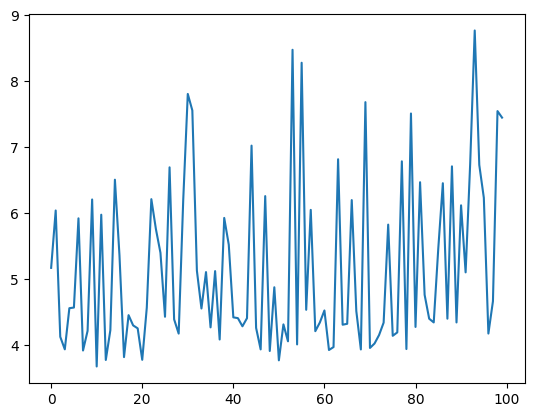

In [12]:
save(batch_size=1, config=params)

patch_core = PatchCore(model, memory_bank_path=memory_bank_path, **params)

test_data = CustomDataset(csv_file="/content/data/open/test.csv", transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
anomaly_score = torch.tensor([], device=device)
with torch.no_grad():
    for idx, x in tqdm(enumerate(test_loader), desc="query"):
        x = x[0].to(device)
        l2 = patch_core.forward(x)

        # for i in range(l2.shape[0]):
        #     wandb.log({"l2": l2[i].item()})
        print(f"l2: {l2}")

        anomaly_score = torch.cat([anomaly_score, l2], dim=0)
        anomaly_score_sorted_idx = anomaly_score.sort(descending=True).indices

anomaly_score = anomaly_score.cpu()
plt.plot(anomaly_score)
plt.show()

In [13]:
# Threshold 보다 크면 이상치로 판별
data = anomaly_score
data = [idx for idx, d in enumerate(data) if d > Threshold]
outliers_idx1 = data
print(outliers_idx1)

[1, 6, 9, 11, 14, 15, 22, 23, 24, 26, 29, 30, 31, 38, 39, 44, 47, 53, 55, 57, 63, 66, 69, 74, 77, 79, 81, 85, 86, 88, 90, 92, 93, 94, 95, 98, 99]


In [14]:
count = 0 #맞은 개수
fault = [] #틀린 것 인덱스
test_label = pd.read_csv('/content/data/open/test.csv')['label'].tolist()

for idx in range(len(test_label)):
  tr = 1 if anomaly_score[idx] > Threshold else 0
  if tr == test_label[idx]:
    count += 1
  else:
    fault.append(idx)

accuracy = count / len(test_label) #정확도
print(accuracy)
print(fault)

0.97
[34, 83, 91]
